In [2]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [3]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [4]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.3)  

train_gen = augs.flow_from_directory(
    '/Users/sakshigupta/Downloads/cell_images 3',
    target_size = (50,50),
    batch_size=16,
    class_mode = 'categorical',
    subset='training')

val_gen = augs.flow_from_directory(
    '/Users/sakshigupta/Downloads/cell_images 3',
    target_size=(50,50),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = False)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)


Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


NameError: name 'x_train' is not defined

In [5]:
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#keras.utils.vis_utils.pydot = pydot

#Visualize Model

#def visualize_model(model):
  # check the layers by name
  #for i,layer in enumerate(model.layers):
      #print(i,layer.name)
  #return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
#visualize_model(model)

def ConvBlock(model, layers, filters,name):
    for i in range(layers):
        model.add(SeparableConv2D(filters, (3, 3), activation='relu',name=name))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(50, 50, 3)))
    ConvBlock(model, 1, 64,'block_1')
    ConvBlock(model, 1, 128,'block_2')
    ConvBlock(model, 1, 256,'block_3')
    ConvBlock(model, 1, 512,'block_4')
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='sigmoid'))
    return model

model = FCN()
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 50, 50, 3)         0         
_________________________________________________________________
block_1 (SeparableConv2D)    (None, 48, 48, 64)        283       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
block_2 (SeparableConv2D)    (None, 22, 22, 128)       8896      
_________________________________________________________________
batch_normalization_2

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [6]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [12]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 1206, 
    validation_data  = val_gen,
    validation_steps = 1206,
    epochs = 10, 
    verbose = 1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1206/1206 [==============================] - 43583s 36s/step - loss: 0.3986 - acc: 0.8177 - val_loss: 0.2428 - val_acc: 0.8989

Epoch 00001: val_loss improved from inf to 0.24278, saving model to ./base.model
Epoch 2/10
1206/1206 [==============================] - 566s 469ms/step - loss: 0.2070 - acc: 0.9263 - val_loss: 0.1933 - val_acc: 0.9252

Epoch 00002: val_loss improved from 0.24278 to 0.19330, saving model to ./base.model
Epoch 3/10
1206/1206 [==============================] - 518s 430ms/step - loss: 0.1905 - acc: 0.9348 - val_loss: 0.1678 - val_acc: 0.9424

Epoch 00003: val_loss improved from 0.19330 to 0.16781, saving model to ./base.model
Epoch 4/10
1206/1206 [==============================] - 602s 499ms/step - loss: 0.1802 - acc: 0.9396 - val_loss: 0.1573 - val_acc: 0.9445

Epoch 00004: val_loss improved from 0.16781 to 0.15735, saving model to ./base.model
Epoch 5/10
1206/1206 [==============================] - 627s

Model Test Loss: 0.25105850398540497
Model Test Accuracy: 0.90625


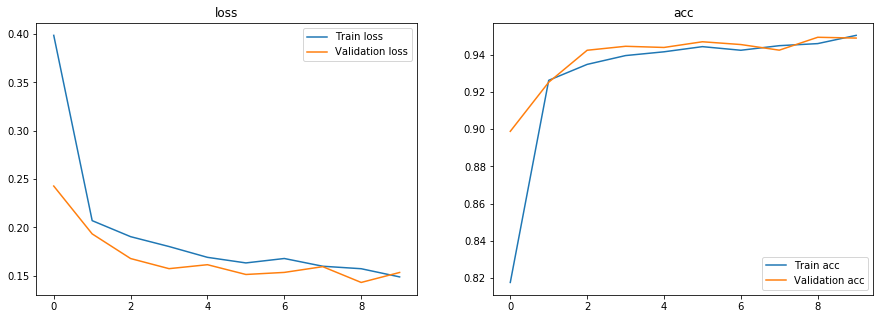

In [13]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(val_gen, steps = 4)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])